# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import json
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC price
bit_res_data = requests.get(btc_url)
bit_res_con = bit_res_data.content
bit_data = bit_res_data.json()
#print(json.dumps(bit_data, indent=4))

# Fetch current ETH price
eth_res_data = requests.get(eth_url)
eth_res_con = eth_res_data.content
eth_data = eth_res_data.json()
#print(json.dumps(eth_data, indent=4))

# Compute current value of my crpto
bit_price = bit_data['data']['1']['quotes']['CAD']['price']
eth_price = eth_data['data']['1027']['quotes']['CAD']['price']

my_btc_value = bit_price * my_btc
my_eth_value = eth_price * my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $30959.00
The current value of your 5.3 ETH is $9564.11


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [8]:
# Format current date as ISO format
today = pd.Timestamp("2020-07-14", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
df_portfolio = alpaca.get_bars(
    tickers,
    timeframe,
    start = today,
    end = today
).df

# Display sample data
df_portfolio

# Reorganize the DataFrame
# Separate ticker data
AGG = df_portfolio[df_portfolio['symbol']=='AGG'].drop('symbol', axis = 1)
SPY = df_portfolio[df_portfolio['symbol']=='SPY'].drop('symbol', axis = 1)

# Concatenate the ticker DataFrames
df_portfolio = pd.concat([AGG, SPY], axis = 1, keys=['AGG', 'SPY'])
df_portfolio.index = df_portfolio.index.date

# Preview DataFrame
df_portfolio

AGG                                                           \
              open    high     low   close   volume trade_count        vwap   
2020-07-14  118.58  118.74  118.58  118.67  3986756       14580  118.667216   

               SPY                                                           
              open    high    low   close    volume trade_count        vwap  
2020-07-14  313.25  319.76  312.0  318.92  93545651      580270  316.244144

In [9]:
# Pick AGG and SPY close prices
agg_close_price = float(df_portfolio['AGG']['close'])
spy_close_price = float(df_portfolio['SPY']['close'])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $118.67
Current SPY closing price: $318.92


In [10]:
# Compute the current value of shares
my_agg_value = my_agg * agg_close_price
my_spy_value = my_spy * spy_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $15946.00
The current value of your 200 AGG shares is $23734.00


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
fin_assets =  [my_btc, my_eth, my_spy, my_agg]
fin_value = [my_btc_value, my_eth_value, my_spy_value, my_agg_value]
tickers = ["BTC", "ETH", "AGG", "SPY"]

# Create savings DataFrame
df_savings = pd.DataFrame(list(zip(fin_assets, fin_value)), columns= ["Assets", "Value"], index=tickers)

# Display savings DataFrame
display(df_savings)

,Assets,Value
BTC,1.2,30959.002627
ETH,5.3,9564.106350
AGG,50.0,15946.000000
SPY,200.0,23734.000000


<AxesSubplot:title={'center':'Portfolio Asset Composition'}, ylabel='Value'>

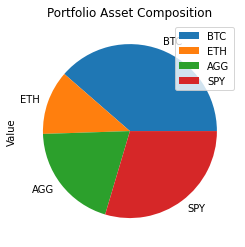

In [12]:
# Plot savings pie chart
df_savings.plot.pie(y="Value", title= "Portfolio Asset Composition")

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_sav = df_savings['Value'].sum()
total_sav

# Validate saving health
if (emergency_fund < total_sav):
    print(f"Savings are healthly, you have ${round(total_sav - emergency_fund, 2)} extra in savings!")
else:
    print(f"Savings are too low! You have a shortfall of ${round(total_sav - emergency_fund,2)}.")
        

Savings are healthly, you have $44203.11 extra in savings!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
tickers= ['SPY', 'AGG']

df_stock_data = alpaca.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = df_stock_data[df_stock_data['symbol']=='AGG'].drop('symbol', axis = 1)
SPY = df_stock_data[df_stock_data['symbol']=='SPY'].drop('symbol', axis = 1)

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([AGG, SPY], axis = 1, keys=['AGG', 'SPY'])
df_stock_data.index = df_stock_data.index.date

# Display sample data
df_stock_data.head()

AGG                                                   \
              open      high       low   close   volume trade_count   
2016-05-02  110.74  110.7400  110.5200  110.61  3553939       15119   
2016-05-03  110.89  110.9450  110.7500  110.81  3044940       15662   
2016-05-04  110.91  110.9315  110.7595  110.86  2920608       13982   
2016-05-05  110.92  111.1600  110.8010  111.14  3008142       15707   
2016-05-06  111.12  111.1200  110.9700  110.97  2718710       12697   

                           SPY                                                 \
                  vwap    open    high     low   close     volume trade_count   
2016-05-02  110.627199  206.90  208.18  206.41  208.03   61908515      263580   
2016-05-03  110.865995  206.50  206.80  205.28  206.13  106422142      377518   
2016-05-04  110.879063  205.00  205.85  204.42  204.96   92199810      345261   
2016-05-05  111.028363  205.57  205.98  204.47  204.95   67597222      280622   
2016-05-06  111.031967  204.04  205.77  203.88  205.70   89131004      340335   

                        
                  vwap  
2016-05-02  207.294812  
2016-05-03  206.312060  
2016-05-04  205.090172  
2016-05-05  205.141555  
2016-05-06  204.937074

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.80,.20],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [17]:
# Printing the simulation input data
MC_30year.portfolio_data.head()

AGG                                                   \
              open      high       low   close   volume trade_count   
2016-05-02  110.74  110.7400  110.5200  110.61  3553939       15119   
2016-05-03  110.89  110.9450  110.7500  110.81  3044940       15662   
2016-05-04  110.91  110.9315  110.7595  110.86  2920608       13982   
2016-05-05  110.92  111.1600  110.8010  111.14  3008142       15707   
2016-05-06  111.12  111.1200  110.9700  110.97  2718710       12697   

                                        SPY                          \
                  vwap daily_return    open    high     low   close   
2016-05-02  110.627199          NaN  206.90  208.18  206.41  208.03   
2016-05-03  110.865995     0.001808  206.50  206.80  205.28  206.13   
2016-05-04  110.879063     0.000451  205.00  205.85  204.42  204.96   
2016-05-05  111.028363     0.002526  205.57  205.98  204.47  204.95   
2016-05-06  111.031967    -0.001530  204.04  205.77  203.88  205.70   

                                                            
               volume trade_count        vwap daily_return  
2016-05-02   61908515      263580  207.294812          NaN  
2016-05-03  106422142      377518  206.312060    -0.009133  
2016-05-04   92199810      345261  205.090172    -0.005676  
2016-05-05   67597222      280622  205.141555    -0.000049  
2016-05-06   89131004      340335  204.937074     0.003659

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 100.


C:\Users\gbras\Python\UTOR-VIRT-FIN-PT-08-2022-U-LOLC\Homework\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 400.


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.003911,1.004650,0.999446,0.999195,0.989717,1.004077,0.995122,1.004512,1.003474,0.998557,...,1.000869,0.996313,1.001898,1.003191,0.995414,1.002952,0.996432,0.998199,1.004975,0.999223
2,1.001245,1.006348,0.996944,0.996061,0.992674,1.001274,0.993326,1.005985,1.002502,0.999690,...,0.997871,0.994164,1.002789,0.997512,0.998403,1.002729,0.992892,0.994483,1.004882,0.999384
3,1.006557,1.011077,0.994363,0.992761,0.993224,1.004188,0.995347,1.005858,1.005981,0.994687,...,0.998942,0.995255,1.003821,1.001681,0.994071,1.001038,0.994250,0.992560,1.008314,0.997868
4,1.005814,1.011425,0.994044,0.991177,0.991789,1.003478,0.999137,1.009065,1.008257,0.993688,...,0.997713,0.993069,1.008339,1.000753,0.994046,1.002435,0.992628,0.996502,1.004792,1.002228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,2.522740,4.582634,2.636886,3.213942,3.796736,2.728680,2.608651,2.582440,2.785763,2.908977,...,3.196005,3.567801,3.806339,1.558915,2.159516,2.479744,3.268228,5.848968,2.204585,4.025703
7557,2.512879,4.601305,2.633783,3.218886,3.799556,2.730507,2.625049,2.589685,2.783102,2.895258,...,3.186138,3.554792,3.829155,1.563126,2.157902,2.486562,3.272639,5.853221,2.203271,4.003261
7558,2.518052,4.577998,2.643963,3.231457,3.803448,2.745882,2.642166,2.586441,2.780910,2.901679,...,3.183074,3.527874,3.829182,1.569504,2.167514,2.477135,3.283336,5.851616,2.218050,4.000145
7559,2.501429,4.594589,2.629116,3.215996,3.839175,2.754853,2.659815,2.591251,2.776726,2.905519,...,3.193868,3.548200,3.812146,1.566433,2.167022,2.480809,3.291051,5.880946,2.219908,3.990863


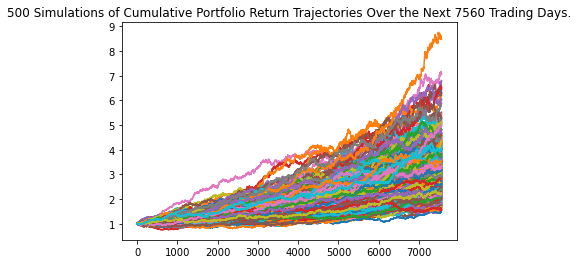

In [19]:
# Plot simulation outcomes
mc30y_plot = MC_30year.plot_simulation()

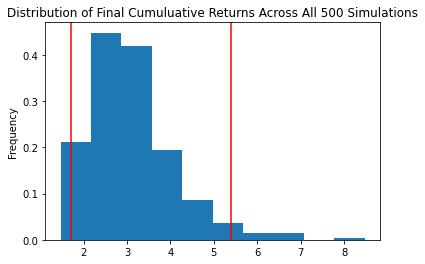

In [20]:
# Plot probability distribution and confidence intervals
dist_plot = MC_30year.plot_distribution()
dist_plot.get_figure().savefig('MC_30year_dist_plot.png',bbox_inches='tight')

### Retirement Analysis

In [21]:
# Fetch summary statistics from the Monte Carlo simulation results
mc_30table = MC_30year.summarize_cumulative_return()

# Print summary statistics
mc_30table

count           500.000000
mean              3.105846
std               0.973200
min               1.469435
25%               2.461532
50%               2.945814
75%               3.557796
max               8.479507
95% CI Lower      1.710819
95% CI Upper      5.397829
Name: 7560, dtype: float64

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [23]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci95_lower = round(mc_30table[8]*initial_investment,2)
ci95_upper = round(mc_30table[9]*initial_investment,2)


# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci95_lower} and ${ci95_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $34216.37 and $107956.58


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [25]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci95_lower = round(mc_30table[8]*initial_investment,2)
ci95_upper = round(mc_30table[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci95_lower} and ${ci95_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $51324.56 and $161934.87


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [26]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyear = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.80,.20],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [27]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 100.


C:\Users\gbras\Python\UTOR-VIRT-FIN-PT-08-2022-U-LOLC\Homework\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 400.


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001472,0.997205,1.002497,1.001828,1.000250,1.003290,0.999471,0.995342,0.991177,1.001894,...,0.997946,0.999281,1.003813,1.002547,1.004327,0.993539,1.003323,1.000766,0.998882,0.998630
2,1.001640,0.997759,1.003995,1.005594,1.002906,0.999754,0.992925,0.992770,0.990032,0.997645,...,0.997622,1.001245,1.000315,0.999694,1.003582,0.988688,1.007271,0.995368,1.001290,0.996769
3,1.002684,0.996744,1.002349,1.006383,0.997673,0.999256,0.998102,0.988793,0.992671,1.008117,...,1.000427,0.994861,0.997051,0.997106,1.009608,0.989792,1.007055,0.996137,0.997256,0.994464
4,1.000972,1.000630,1.003558,1.007304,1.002930,1.005206,0.996133,0.988466,0.997803,1.005406,...,0.999173,0.999577,0.995252,0.996839,1.005911,0.990150,1.004433,0.996117,0.992489,0.990791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.332157,1.040569,1.000486,1.336289,1.020606,1.208086,1.003184,0.963341,1.156337,1.286272,...,1.547849,1.151604,1.158094,1.201833,1.012922,1.246237,1.247006,1.401535,1.357956,1.233937
1257,1.325487,1.045550,1.003704,1.339651,1.026567,1.210327,1.005630,0.968004,1.153044,1.287855,...,1.551571,1.154446,1.159957,1.203117,1.014004,1.238393,1.243738,1.400551,1.357608,1.234094
1258,1.321747,1.038852,0.996890,1.339087,1.022917,1.215208,1.011644,0.968251,1.157783,1.286817,...,1.552495,1.155621,1.156550,1.210154,1.015935,1.238706,1.240210,1.388482,1.352989,1.238088
1259,1.320251,1.038005,0.993575,1.341848,1.025813,1.216068,1.014792,0.963481,1.155762,1.285353,...,1.563009,1.164959,1.158242,1.210036,1.014211,1.241048,1.240874,1.392626,1.349905,1.236880


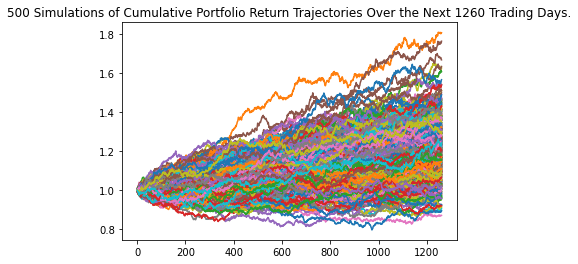

In [28]:
# Plot simulation outcomes
mc5y_plot = MC_fiveyear.plot_simulation()

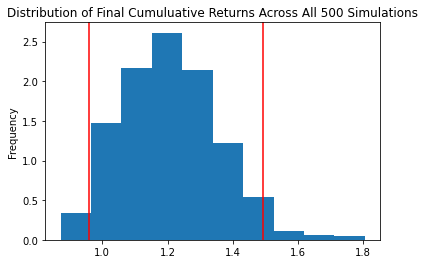

In [29]:
# Plot probability distribution and confidence intervals
dist_plot = MC_fiveyear.plot_distribution()
dist_plot.get_figure().savefig('MC_fiveyear_dist_plot.png',bbox_inches='tight')

In [30]:
# Fetch summary statistics from the Monte Carlo simulation results
mc_5table = MC_fiveyear.summarize_cumulative_return()

# Print summary statistics
mc_5table

count           500.000000
mean              1.208242
std               0.146464
min               0.871593
25%               1.103905
50%               1.201736
75%               1.304748
max               1.805510
95% CI Lower      0.959478
95% CI Upper      1.493357
Name: 1260, dtype: float64

In [32]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci95_lower_five = round(mc_5table[8]*initial_investment,2)
ci95_upper_five = round(mc_5table[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci95_lower_five} and ${ci95_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $57568.66 and $89601.43


### Ten Years Retirement Option

In [33]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyear = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.80,.20],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [34]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 100.


C:\Users\gbras\Python\UTOR-VIRT-FIN-PT-08-2022-U-LOLC\Homework\05-APIs\Instructions\Starter_Code\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 400.


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996793,0.999528,1.000980,1.001654,0.999739,1.000363,1.003080,1.001582,0.995589,0.996140,...,1.000044,1.002686,0.997899,1.002214,0.998960,1.001129,0.995411,0.999442,1.004612,0.998122
2,1.000789,1.002364,0.999907,0.997833,0.998149,1.005439,1.010508,1.005284,0.996393,0.998001,...,1.001871,1.007809,0.994090,1.007467,1.003230,1.005179,0.995334,1.001303,1.004714,0.997377
3,0.997885,0.998396,1.001542,0.995291,1.005369,1.005761,1.004790,1.007824,1.000804,0.994815,...,1.000552,1.003556,0.995125,1.007836,1.003775,1.003042,1.001410,1.000367,1.001947,0.997295
4,0.994759,0.998446,0.999275,0.991881,1.008470,1.008907,1.007707,1.009330,1.003546,0.994812,...,1.000876,1.004653,0.994989,1.014134,1.005257,1.005754,1.001381,1.009045,1.001452,0.999403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.341557,1.561397,1.665733,1.445668,1.101265,1.640761,1.451288,1.321996,1.534348,1.305459,...,1.150089,1.151807,1.423756,1.445888,1.297549,1.175357,1.367325,1.383955,1.222888,1.928686
2517,1.333767,1.561458,1.671127,1.445563,1.101221,1.643274,1.452748,1.319622,1.536485,1.308427,...,1.148136,1.147921,1.423894,1.447405,1.289709,1.171627,1.374348,1.378271,1.221604,1.928503
2518,1.332706,1.560519,1.670149,1.450188,1.105846,1.643425,1.454542,1.327003,1.542890,1.309884,...,1.149751,1.153259,1.428189,1.445192,1.285192,1.177859,1.377056,1.389283,1.220395,1.927773
2519,1.327964,1.565843,1.677576,1.448311,1.105181,1.650188,1.453244,1.328045,1.539885,1.309596,...,1.152787,1.152719,1.422483,1.444141,1.284951,1.174380,1.384961,1.381012,1.222144,1.929770


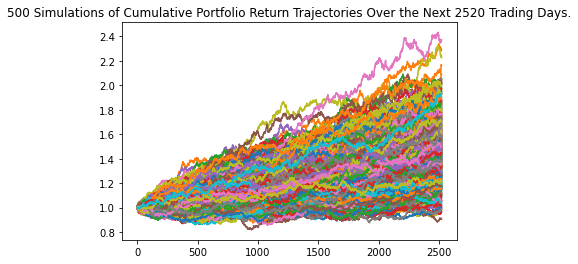

In [35]:
# Plot simulation outcomes
mc10y_plot = MC_tenyear.plot_simulation()

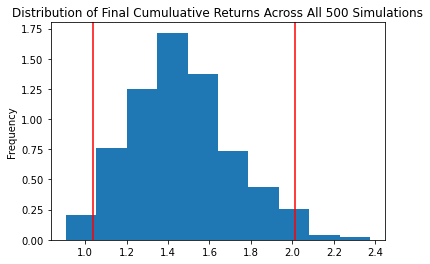

In [36]:
# Plot probability distribution and confidence intervals
dist_plot = MC_tenyear.plot_distribution()
dist_plot.get_figure().savefig('MC_tenyear_dist_plot.png',bbox_inches='tight')

In [37]:
# Fetch summary statistics from the Monte Carlo simulation results
mc_10table = MC_tenyear.summarize_cumulative_return()

# Print summary statistics
mc_10table

count           500.000000
mean              1.466485
std               0.247467
min               0.906948
25%               1.285697
50%               1.446893
75%               1.608865
max               2.375205
95% CI Lower      1.036169
95% CI Upper      2.010496
Name: 2520, dtype: float64

In [41]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci95_lower_ten = round(mc_30table[8]*initial_investment,2)
ci95_upper_ten = round(mc_30table[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci95_lower_ten} and ${ci95_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $102649.11 and $323869.74
